In [1]:
import numpy as np

In [2]:
topic = {}
tfidf = dict(list(zip('cat dog apple lion NYC love'.split(), np.random.rand(6))))
topic['pet'] = (.3 * tfidf['cat'] + .3 * tfidf['dog'] + 0 * tfidf['apple']
                + 0 * tfidf['lion'] - .2 * tfidf['NYC'] + .2 * tfidf['love'])
topic['animal'] = (.1 * tfidf['cat'] + .1 * tfidf['dog'] - .1 * tfidf['apple']
                   + .5 * tfidf['lion'] + .1 * tfidf['NYC'] - .1 * tfidf['love'])
topic['city'] = (0 * tfidf['cat'] - .1 * tfidf['dog'] + .2 * tfidf['apple']
                 - .1 * tfidf['lion'] + .5 * tfidf['NYC'] + .1 * tfidf['love'])

In [3]:
tfidf

{'cat': 0.7871217007207626,
 'dog': 0.341972272659923,
 'apple': 0.8760071240525025,
 'lion': 0.6428226793324111,
 'NYC': 0.27245107242850464,
 'love': 0.4069084567594503}

In [4]:
topic

{'pet': 0.3656196688803948,
 'animal': 0.33327428616592925,
 'city': 0.25363831150146443}

In [5]:
word_vector = {}
word_vector['cat'] = .3 * topic['pet'] + .1 * topic['animal'] + 0 * topic['city']
word_vector['dog'] = .3 * topic['pet'] + .1 * topic['animal'] - .1 * topic['city']
word_vector['apple'] = 0 * topic['pet'] - .1 * topic['animal'] + .2 * topic['city']
word_vector['lion'] = 0 * topic['pet'] + .5 * topic['animal'] - .1 * topic['city']
word_vector['NYC'] = -.2 * topic['pet'] + .1 * topic['animal'] + .5 * topic['city']
word_vector['love'] = .2 * topic['pet'] - .1 * topic['animal'] + .1 * topic['city']
word_vector

{'cat': 0.14301332928071137,
 'dog': 0.11764949813056493,
 'apple': 0.01740023368369996,
 'lion': 0.14127331193281817,
 'NYC': 0.08702265059124617,
 'love': 0.06516033630963249}

### 4.1.5 An LDA classifier

In [6]:
from nlpia.data.loaders import get_data
import pandas as pd

2023-03-20 15:35:51.427740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/yeabinmoon/opt/anaconda3/envs/tensorflow_env/lib/python3.9/site-packages/pugnlp/constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
/Users/yeabinmoon/opt/anaconda3/envs/tensorflow_env/lib/python3.9/site-packages/pugnlp/constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
/Users/yea

In [7]:
pd.options.display.width = 120

In [8]:
sms = get_data('sms-spam')
index = ['sms{}{}'.format(i, '!'*j) for (i,j) in zip(range(len(sms)), sms.spam)] 
sms = pd.DataFrame(sms.values, columns=sms.columns, index=index)

In [9]:
sms['spam']

sms0        0
sms1        0
sms2!       1
sms3        0
sms4        0
           ..
sms4832!    1
sms4833     0
sms4834     0
sms4835     0
sms4836     0
Name: spam, Length: 4837, dtype: object

In [10]:
sms['spam'] = sms.spam.astype(int)

In [11]:
len(sms)

4837

In [12]:
sms.spam.sum()

638

In [13]:
sms.head(6)

,spam,text
sms0,0,"Go until jurong point, crazy.. Available only ..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives aro..."
sms5!,1,FreeMsg Hey there darling it's been 3 week's n...


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

In [15]:
tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)

In [16]:
tfidf_docs = tfidf_model.fit_transform(raw_documents=sms.text).toarray()

/Users/yeabinmoon/opt/anaconda3/envs/tensorflow_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [17]:
tfidf_docs.shape

(4837, 9232)

In [19]:
sms.spam.sum()

638

In [22]:
mask = sms.spam.astype(bool).values

In [32]:
spam_centroid = tfidf_docs[mask].mean(axis=0)

In [33]:
ham_centroid = tfidf_docs[~mask].mean(axis=0)

In [34]:
spam_centroid.round(2)

array([0.06, 0.  , 0.  , ..., 0.  , 0.  , 0.  ])

In [35]:
spam_centroid.shape

(9232,)

In [36]:
ham_centroid.round(2)

array([0.02, 0.01, 0.  , ..., 0.  , 0.  , 0.  ])

In [37]:
ham_centroid.shape

(9232,)

In [44]:
spamminess_score = tfidf_docs.dot(spam_centroid - ham_centroid)

In [46]:
print(spamminess_score.round(2))
print(spamminess_score.shape)

[-0.01 -0.02  0.04 ... -0.01 -0.    0.  ]
(4837,)


In [48]:
from sklearn.preprocessing import MinMaxScaler

In [47]:
tfidf_docs.shape

(4837, 9232)

In [50]:
sms['lda_score'] = MinMaxScaler().fit_transform(spamminess_score.reshape(-1,1))

In [51]:
sms['lda_predict'] = (sms.lda_score > .5).astype(int)

In [52]:
sms

,spam,text,lda_score,lda_predict
sms0,0,"Go until jurong point, crazy.. Available only ...",0.227478,0
sms1,0,Ok lar... Joking wif u oni...,0.177888,0
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...,0.718785,1
sms3,0,U dun say so early hor... U c already then say...,0.184565,0
sms4,0,"Nah I don't think he goes to usf, he lives aro...",0.286944,0
...,...,...,...,...
sms4832!,1,This is the 2nd time we have tried 2 contact u...,0.850649,1
sms4833,0,Will ü b going to esplanade fr home?,0.292753,0
sms4834,0,"Pity, * was in mood for that. So...any other s...",0.269454,0
sms4835,0,The guy did some bitching but I acted like i'd...,0.331306,0


In [53]:
(1. - (sms.spam - sms.lda_predict).abs().sum() / len(sms)).round(3)

0.977

In [55]:
from sklearn.metrics import confusion_matrix

In [56]:
confusion_matrix(sms.spam, sms.lda_predict)

array([[4135,   64],
       [  45,  593]])

### 2-dimensional plot

Text(0, 0.5, ' y')

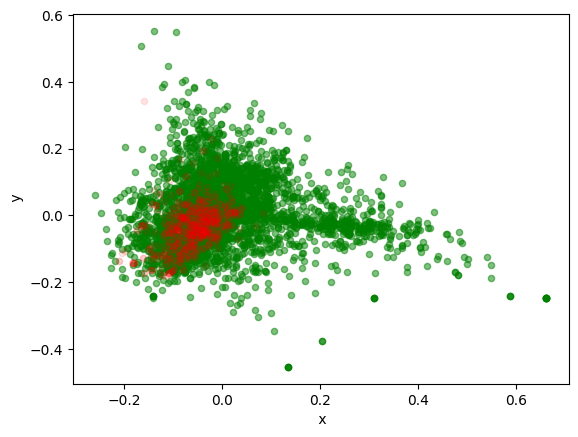

In [63]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn
pca_model = PCA(n_components=3)
tfidf_docs_3d = pca_model.fit_transform(tfidf_docs)
df = pd.DataFrame(tfidf_docs_3d)
ax = df[~mask].plot(x=0, y=1, kind='scatter', alpha=.5, c='green')
df[mask].plot(x=0, y=1, ax=ax, alpha=.1, kind='scatter', c='red')
plt.xlabel(' x')
plt.ylabel(' y')

### 3-dimensional plot

In [64]:
import plotly as py
spam_trace = dict(
        x=df[0][mask], y=df[1][mask], z=df[2][mask],
        type="scatter3d", mode='markers',
        marker= dict(size=3, color='red', line=dict(width=0)) 
    )
ham_trace = dict(
        x=df[0][~mask], y=df[1][~mask], z=df[2][~mask],
        type="scatter3d", mode='markers',
        marker= dict(size=3, color='green', line=dict(width=0)) 
    )
fig = dict(data=[ham_trace, spam_trace], layout={'title': 'LDA Spamminess Model'})
py.offline.plot(fig, filename='lda_spam_3d_scatter.html')

'lda_spam_3d_scatter.html'

## 4.2 Latent semantic analysis

**What' does the following lines do?**

In [65]:
from nlpia.book.examples.ch04_catdog_lsa_3x6x16 import word_topic_vectors
word_topic_vectors.T.round(1)

100%|██████████| 263/263 [00:00<00:00, 80925.97it/s]


,cat,dog,apple,lion,nyc,love
top0,-0.6,-0.4,0.5,-0.3,0.4,-0.1
top1,-0.1,-0.3,-0.4,-0.1,0.1,0.8
top2,-0.3,0.8,-0.1,-0.5,0.0,0.1


## 4.3 Singular value decomposition